In [40]:
import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import pandas as pd

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TextVectorization

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA

print(tf.__version__)


2.10.0


In [59]:

# Load the data into a pandas dataframe
data_path = "../data/malware_dataset.csv"
data = pd.read_csv(data_path)

# Convert classification column from string values into numerical values
# 0 - malware , 1 - benign
le = LabelEncoder()
data["classification"] = le.fit_transform(data["classification"])

# Drop the classification from input data and pass it in as output
features = data.drop(columns=["classification"])

print(features.shape)

# Perform PCA to reduce dimensionaliy
# ty
pca = PCA(n_components=34)
features = pca.fit_transform(features)

# Normalize features
# Mean of 0 and Standard deviation of 1 to highlight large features
scaler = StandardScaler()
features = scaler.fit_transform(features)

# Split into training and testing sets
train_data, test_data, train_labels, test_labels = train_test_split(
    features, data["classification"], test_size=0.2, random_state=42)





(100000, 34)
[[-1.68876372e-01 -5.54340676e-01 -8.11903704e-01 ...  2.31709626e-02
  -7.54324879e-03 -7.53884861e-03]
 [-1.68292468e-01  4.12930887e-01 -1.06697105e+00 ...  1.08563311e-02
   6.13581491e-03  6.14824686e-03]
 [ 9.46933952e-01 -4.32876679e-01  1.09476509e+00 ... -4.73149009e-03
  -5.70313811e-03 -5.72114279e-03]
 ...
 [-1.67777442e-01  1.25838259e+00  1.40367275e-01 ...  1.28778220e-01
  -1.26542566e-02 -1.26333616e-02]
 [-1.68679931e-01 -2.62557519e-01 -3.97314912e-02 ... -5.28132363e-03
   6.04010259e-03  6.04800054e-03]
 [-1.56252695e-01 -1.46406176e+00  6.04317679e-01 ... -3.76137867e-02
   2.96027306e-04  2.93465987e-04]]


In [47]:
# PCA "n_components" output
input_dim = 34

input_layer = tf.keras.layers.Input(shape=(input_dim,))
encoder = tf.keras.layers.Dense(64, activation='relu')(input_layer)
encoder = tf.keras.layers.Dense(32, activation='relu')(encoder)
encoder = tf.keras.layers.Dense(32, activation='relu')(encoder)

# Build decoder network
decoder = tf.keras.layers.Dense(32, activation='relu')(encoder)
decoder = tf.keras.layers.Dense(64, activation='relu')(decoder)
decoder = tf.keras.layers.Dense(input_dim, activation='linear')(decoder)

# Combine encoder and decoder into autoencoder
autoencoder = tf.keras.models.Model(inputs=input_layer, outputs=decoder)

autoencoder.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 34)]              0         
                                                                 
 dense_2 (Dense)             (None, 64)                2240      
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dense_4 (Dense)             (None, 32)                1056      
                                                                 
 dense_5 (Dense)             (None, 32)                1056      
                                                                 
 dense_6 (Dense)             (None, 64)                2112      
                                                                 
 dense_7 (Dense)             (None, 34)                2210  

In [49]:
autoencoder.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
history = autoencoder.fit(train_data, train_data, epochs=10,
                batch_size=128, verbose=1)

Epoch 1/10


2023-04-13 10:57:06.936458: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


625/625 [==============================] - 1s 808us/step - loss: 0.7732 - accuracy: 0.4413
Epoch 2/10
625/625 [==============================] - 1s 818us/step - loss: 0.5935 - accuracy: 0.5703
Epoch 3/10
625/625 [==============================] - 1s 801us/step - loss: 0.5312 - accuracy: 0.6810
Epoch 4/10
625/625 [==============================] - 0s 797us/step - loss: 0.4737 - accuracy: 0.7453
Epoch 5/10
625/625 [==============================] - 1s 1ms/step - loss: 0.4668 - accuracy: 0.7672
Epoch 6/10
625/625 [==============================] - 1s 806us/step - loss: 0.4278 - accuracy: 0.7726
Epoch 7/10
625/625 [==============================] - 0s 786us/step - loss: 0.4025 - accuracy: 0.7703
Epoch 8/10
625/625 [==============================] - 1s 808us/step - loss: 0.3611 - accuracy: 0.7936
Epoch 9/10
625/625 [==============================] - 0s 799us/step - loss: 0.3442 - accuracy: 0.8055
Epoch 10/10
625/625 [==============================] - 0s 799us/step - loss: 0.3196 - accuracy:

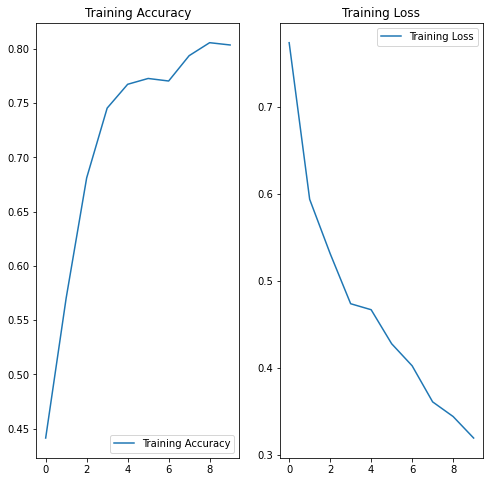

In [55]:
train_loss = history.history['loss']
train_acc = history.history['accuracy']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_acc, label='Training Accuracy')
plt.legend(loc='lower right')
plt.title('Training Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_loss, label='Training Loss')
plt.legend(loc='upper right')
plt.title('Training Loss')
plt.show()


In [ ]:
# Detect Anomalies through this
reconstructions = autoencoder.predict(test_data)
reconstruction_error = np.mean(np.abs(reconstructions - test_data), axis=1)
threshold = np.mean(reconstruction_error) + np.std(reconstruction_error)
anomalies = np.where(reconstruction_error > threshold, 1, 0)

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu',
                           input_shape=34),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(2, activation='sigmoid')
])

model.summary()

model.compile(optimizer='adam',
              loss='binary_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_data, train_labels, epochs=10, batch_size=128, verbose=1)


In [ ]:
train_loss = history.history['loss']
train_acc = history.history['accuracy']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_acc, label='Training Accuracy')
plt.legend(loc='lower right')
plt.title('Training Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_loss, label='Training Loss')
plt.legend(loc='upper right')
plt.title('Training Loss')
plt.show()

In [ ]:
predictions = model.predict(test_data)
predicted_labels = np.argmax(predictions, axis=1)

In [ ]:
# Ensembling module
# Predictions and Anomalies
def majority_voting(labels1, labels2):
    # Combine labels using majority voting
    combined_labels = np.where((labels1 + labels2) > 1, 1, 0)
    return combined_labels
